# A Simple Multiple Choice Question Answering Task

In this series of notebooks, we will walk through an example of causal abstraction analysis on trivial multiple-choice questions.

In this first notebook, we introduce (1) a simple multiple choice question answering dataset, (2) a causal model with a single intermediate variable for the **position** of the correct answer, and (3) an original-counterfactual input pair that can distinguish the positional variable from the output of the model.  

In each question, we ask simply state the color of an object and then ask what color that object is (originally from [Wiegreffe et al. 2024](https://arxiv.org/abs/2407.15018)). For example:

The cauliflower is white. What color is the cauliflower?

A. yellow

B. white

Answer: B

In [5]:
%load_ext autoreload
%autoreload 2

import logging
import random

from causalab.causal.causal_viz import print_structure
from causalab.tasks.MCQA.causal_models import positional_causal_model
from causalab.tasks.MCQA.counterfactuals import sample_answerable_question

# Enable logging to see output from can_distinguish_with_dataset
logging.basicConfig(level=logging.INFO)
logging.getLogger("causal.causal_model").setLevel(logging.DEBUG)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



# A Causal Model for MCQA with a Positional Variable

A causal model is a directed graph of **variables** that each have a **mechanism** that determines the variables **value** based on the values of its parents. 


The causal model we load below creates a simple multiple choice question answering (MCQA) dataset where world knowledge about the color of an object is stated and then the color of that object is asked about. We have input variables for the answer choices and the symbol associated with each choice, an object/color pair, and a template for embedding the object, color, choices, and symbols into a well-formed multiple choice question. 

The crux of the model is the intermediary variable with a mechanism that determines the position of the correct choice, which feeds into the output variable with a mechanism that uses the positional information select the right answer. 

Finally, every causal model in this code base is required to have two particular variables: 
- "raw_input" is the variable with a value that can be plugged into a neural network via Pipeline.load().
- "raw_output" is the variable with a value that can be compared with Pipeline.dump(), the neural network output.

In this setting, raw_input variable uses the template to form an LM query and the raw_output is simply a direct copy of the answer.

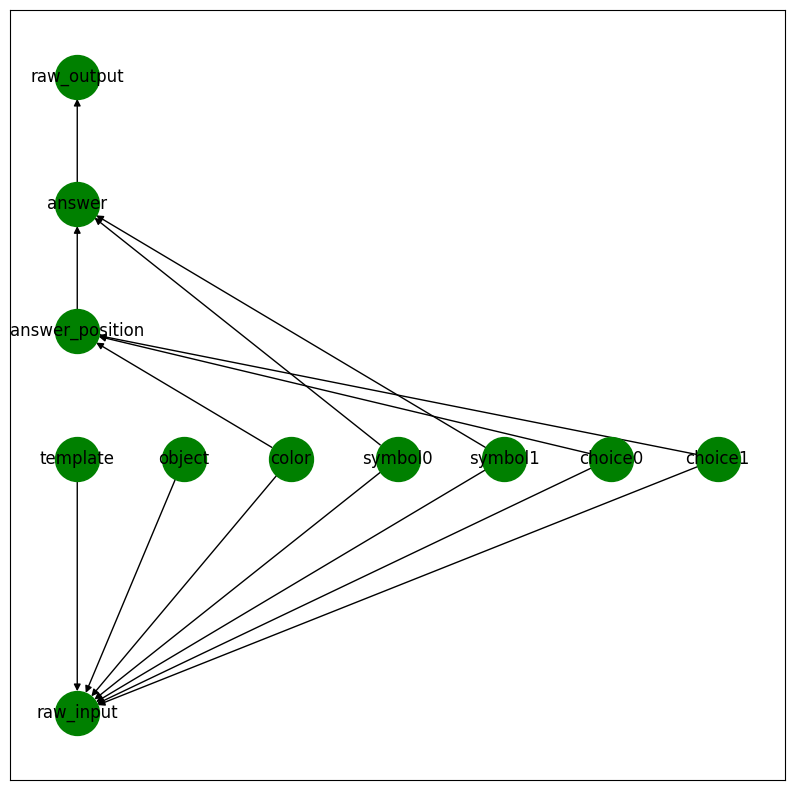

In [6]:
causal_model = positional_causal_model

print_structure(causal_model)


Causal model inputs are dictionaries from **input** variable to values.

In [7]:
example = sample_answerable_question()
print("Example input:")
for k, v in example.items():
    print(f'{k}:\n "{v}"\n')

Example input:
template:
 "The {object} is {color}. What color is the {object}?
{symbol0}. {choice0}
{symbol1}. {choice1}
Answer:"

object:
 "ball"

color:
 "brown"

symbol0:
 "R"

symbol1:
 "B"

choice0:
 "brown"

choice1:
 "green"

raw_input:
 "The ball is brown. What color is the ball?
R. brown
B. green
Answer:"



When we run a causal model on an input, the result is a dictionary mapping from **all** variables to values. Below we print out the only non-input variables:

In [8]:
full_setting = causal_model.run_forward(example)
print("\nFull setting determined by the causal model:")

print(f'"answer_position":\n "{full_setting["answer_position"]}"\n')
print(f'"answer":\n "{full_setting["answer"]}"\n')


Full setting determined by the causal model:
"answer_position":
 "0"

"answer":
 "R"



# Interchange Interventions on Causal Models

We can perform an intervention on the causal model that fixes the value of a variable. For example, we can fix the answer position:

In [9]:
example["answer_position"] = int(not full_setting["answer_position"])
full_setting = causal_model.run_forward(example)
print("\nFull setting determined by the causal model:")

print(f'"answer_position":\n "{full_setting["answer_position"]}"\n')
print(f'"answer":\n "{full_setting["answer"]}"\n')


Full setting determined by the causal model:
"answer_position":
 "1"

"answer":
 "B"



**Interchange interventions** are a special kind of intervention where an **original input** is provided to a causal model and a variable is fixed to the value they would have taken if a **counterfactual input** were provided. 

For example, we can fix the answer position to be the value it would have taken if a different input were provided:

In [10]:
# Generate a new example where the answer position is different
new_example = sample_answerable_question()
new_full_setting = causal_model.run_forward(new_example)
while new_full_setting["answer_position"] == full_setting["answer_position"]:
    new_example = sample_answerable_question()
    new_full_setting = causal_model.run_forward(new_example)

# Print the old example
print("Old example input:\n")
print(full_setting["raw_input"])

# Print the new example
print("New example input:\n")
print(new_full_setting["raw_input"])

# Perform the interchange intervention
intervened_full_setting = causal_model.run_interchange(
    example, {"answer_position": new_example}
)
print(f'"answer_position":\n "{intervened_full_setting["answer_position"]}"\n')
print(f'"answer":\n "{intervened_full_setting["answer"]}"\n')

Old example input:

The ball is brown. What color is the ball?
R. brown
B. green
Answer:
New example input:

The car is green. What color is the car?
S. green
N. purple
Answer:
"answer_position":
 "0"

"answer":
 "R"



# Designing Counterfactual Datasets to Localize Causal Variables

An interchange intervention with the **same** original-counterfactual input pair on **different** variables can produce the **same** output. In this case, we say that the counterfactual confounds the two variables. 

For example, consider the case when both inputs have the same symbols:

In [11]:
import copy

example = sample_answerable_question()
full_setting = causal_model.run_forward(example)

print("Original input:")
print(full_setting["raw_input"])

print("answer_position:", full_setting["answer_position"])

new_example = copy.deepcopy(example)
new_example["object"] = "toy"
new_example["color"] = example[f"choice{int(not full_setting['answer_position'])}"]
new_full_setting = causal_model.run_forward(new_example)
print("\nNew input with same symbols but different answer:")
print(new_full_setting["raw_input"])
print("answer_position:", new_full_setting["answer_position"])

print("\nInterchange intervention fixing answer_position to new example's value:")
print(causal_model.run_interchange(example, {"answer_position": new_example})["answer"])

print("\nInterchange intervention fixing answer to new example's value:")
print(causal_model.run_interchange(example, {"answer": new_example})["answer"])

Original input:
The cup is orange. What color is the cup?
Y. orange
U. pink
Answer:
answer_position: 0

New input with same symbols but different answer:
The toy is pink. What color is the toy?
Y. orange
U. pink
Answer:
answer_position: 1

Interchange intervention fixing answer_position to new example's value:
U

Interchange intervention fixing answer to new example's value:
U


However, we can deconfound the "answer" and "answer_position" variables by modifying the counterfactual to contain new multiple choice answer symbols, which results in interchange interventions on "answer" and "answer_position" having different effects:

In [12]:
print("Original input:")
print(full_setting["raw_input"])

print("answer_position:", full_setting["answer_position"])

new_example2 = copy.deepcopy(example)
new_example2["object"] = "toy"
new_example2["color"] = example[f"choice{int(not full_setting['answer_position'])}"]
new_symbols = list(
    {"A", "B", "C", "D"}.difference({full_setting["symbol0"], full_setting["symbol1"]})
)
new_example2["symbol0"] = random.choice(new_symbols)
new_full_setting = causal_model.run_forward(new_example2)
print("\nNew input with different symbols and different answer:")
print(new_full_setting["raw_input"])
print("answer_position:", new_full_setting["answer_position"])

print("\nInterchange intervention fixing answer_position to new example's value:")
print(
    causal_model.run_interchange(example, {"answer_position": new_example2})["answer"]
)

print("\nInterchange intervention fixing answer to new example's value:")
print(causal_model.run_interchange(example, {"answer": new_example2})["answer"])

Original input:
The cup is orange. What color is the cup?
Y. orange
U. pink
Answer:
answer_position: 0

New input with different symbols and different answer:
The toy is pink. What color is the toy?
D. orange
U. pink
Answer:
answer_position: 1

Interchange intervention fixing answer_position to new example's value:
U

Interchange intervention fixing answer to new example's value:
U


Causal models have a built in function that will evaluate whether a given (dataset of) counterfactuals can distinguish between two sets of variables with interchange interventions:

In [13]:
print(
    "The first pair of inputs confounds the 'answer' and 'answer_position' variables, while the second pair deconfounds them:"
)
causal_model.can_distinguish_with_dataset(
    [{"input": example, "counterfactual_inputs": [new_example]}],
    ["answer_position"],
    ["answer"],
)
causal_model.can_distinguish_with_dataset(
    [{"input": example, "counterfactual_inputs": [new_example2]}],
    ["answer_position"],
    ["answer"],
)

DEBUG:causal.causal_model:Can distinguish between ['answer_position'] and ['answer']: 0 out of 1 examples
DEBUG:causal.causal_model:Proportion of distinguishable examples: 0.00
DEBUG:causal.causal_model:Can distinguish between ['answer_position'] and ['answer']: 0 out of 1 examples
DEBUG:causal.causal_model:Proportion of distinguishable examples: 0.00


The first pair of inputs confounds the 'answer' and 'answer_position' variables, while the second pair deconfounds them:


{'proportion': 0.0, 'count': 0}

# The Discriminative Power of Counterfactual Datasets

We can perform interchange interventions on the causal model with datsets of original-counterfactual pairs to evaluate their ability to distinguish the following: (1) the answer variable, (2) the positional variable, and (3) no intervention. 

We will begin with a dataset of random pairs.

In [14]:
from causalab.causal.counterfactual_dataset import CounterfactualDataset
from causalab.tasks.MCQA.counterfactuals import random_counterfactual

random_pairs = CounterfactualDataset.from_sampler(64, random_counterfactual)

print(random_pairs[0])
print("Original input:")
print(random_pairs[0]["input"]["raw_input"])
print("\nCounterfactual input:")
print(random_pairs[0]["counterfactual_inputs"][0]["raw_input"])

{'input': {'choice0': 'yellow', 'choice1': 'black', 'color': 'yellow', 'object': 'pen', 'raw_input': 'The pen is yellow. What color is the pen?\nJ. yellow\nN. black\nAnswer:', 'symbol0': 'J', 'symbol1': 'N', 'template': 'The {object} is {color}. What color is the {object}?\n{symbol0}. {choice0}\n{symbol1}. {choice1}\nAnswer:'}, 'counterfactual_inputs': [{'choice0': 'purple', 'choice1': 'pink', 'color': 'pink', 'object': 'hat', 'raw_input': 'The hat is pink. What color is the hat?\nG. purple\nL. pink\nAnswer:', 'symbol0': 'G', 'symbol1': 'L', 'template': 'The {object} is {color}. What color is the {object}?\n{symbol0}. {choice0}\n{symbol1}. {choice1}\nAnswer:'}]}
Original input:
The pen is yellow. What color is the pen?
J. yellow
N. black
Answer:

Counterfactual input:
The hat is pink. What color is the hat?
G. purple
L. pink
Answer:


Random pairs for our task actually carry a decent signal to distinguish these three variables. 
- The answer is only confounded with no intervention when the original and counterfactual have the same output (1 in 26 chance)
- The answer_position is confounded when the original and counterfactual have answers in the same position (1 in 2 chance)
- The answer and answer_position variables are only confounded when the counterfactual answer is the same letter as the original symbol at the counterfactual answers position (1 in 26 chance)

In [15]:
causal_model.can_distinguish_with_dataset(random_pairs, ["answer"], None)
causal_model.can_distinguish_with_dataset(random_pairs, ["answer_position"], None)
causal_model.can_distinguish_with_dataset(random_pairs, ["answer"], ["answer_position"])

DEBUG:causal.causal_model:Can distinguish between ['answer'] and None: 63 out of 64 examples
DEBUG:causal.causal_model:Proportion of distinguishable examples: 0.98
DEBUG:causal.causal_model:Can distinguish between ['answer_position'] and None: 30 out of 64 examples
DEBUG:causal.causal_model:Proportion of distinguishable examples: 0.47
DEBUG:causal.causal_model:Can distinguish between ['answer'] and ['answer_position']: 62 out of 64 examples
DEBUG:causal.causal_model:Proportion of distinguishable examples: 0.97


{'proportion': 0.96875, 'count': 62}

We can also construct a dataset where the counterfactual is identical to the original except for having new symbols.

In [16]:
from causalab.causal.counterfactual_dataset import CounterfactualDataset
from causalab.tasks.MCQA.counterfactuals import different_symbol

different_symbol_pairs = CounterfactualDataset.from_sampler(64, different_symbol)

print(different_symbol_pairs[0])
print("Original input:")
print(different_symbol_pairs[0]["input"]["raw_input"])
print("\nCounterfactual input:")
print(different_symbol_pairs[0]["counterfactual_inputs"][0]["raw_input"])

{'input': {'choice0': 'brown', 'choice1': 'white', 'color': 'white', 'object': 'flower', 'raw_input': 'The flower is white. What color is the flower?\nD. brown\nA. white\nAnswer:', 'symbol0': 'D', 'symbol1': 'A', 'template': 'The {object} is {color}. What color is the {object}?\n{symbol0}. {choice0}\n{symbol1}. {choice1}\nAnswer:'}, 'counterfactual_inputs': [{'choice0': 'brown', 'choice1': 'white', 'color': 'white', 'object': 'flower', 'raw_input': 'The flower is white. What color is the flower?\nM. brown\nO. white\nAnswer:', 'symbol0': 'M', 'symbol1': 'O', 'template': 'The {object} is {color}. What color is the {object}?\n{symbol0}. {choice0}\n{symbol1}. {choice1}\nAnswer:'}]}
Original input:
The flower is white. What color is the flower?
D. brown
A. white
Answer:

Counterfactual input:
The flower is white. What color is the flower?
M. brown
O. white
Answer:


This counterfactual dataset is designed to localize the answer variable:
- The answer is never confounded with no intervention, because the original and counterfactual have distinct output 
- The answer_position is never confounded with the no intervention, because the counterfactual has an answer in the same position as the original
- The answer and answer_position variables are never confounded, because interventions on the position produce an output symbol from the original, and interventions on the answer produce a distinct output symbol from the counterfactual

In [17]:
causal_model.can_distinguish_with_dataset(different_symbol_pairs, ["answer"], None)
causal_model.can_distinguish_with_dataset(
    different_symbol_pairs, ["answer_position"], None
)
causal_model.can_distinguish_with_dataset(
    different_symbol_pairs, ["answer"], ["answer_position"]
)

DEBUG:causal.causal_model:Can distinguish between ['answer'] and None: 64 out of 64 examples
DEBUG:causal.causal_model:Proportion of distinguishable examples: 1.00
DEBUG:causal.causal_model:Can distinguish between ['answer_position'] and None: 0 out of 64 examples
DEBUG:causal.causal_model:Proportion of distinguishable examples: 0.00
DEBUG:causal.causal_model:Can distinguish between ['answer'] and ['answer_position']: 64 out of 64 examples
DEBUG:causal.causal_model:Proportion of distinguishable examples: 1.00


{'proportion': 1.0, 'count': 64}

# Takeaways

Designing causal models and counterfactuals is an essential part of the research workflow for causal abstraction analysis of neural networks. The causal model is the hypothesis about neural network structure, and the counterfactuals are the tools we can use to experimentally test our hypothesis. 

This process can begin without touching a neural network, e.g., this notebook doesn't load in any language models. If our hypothesized causal model is entirely correct, then the counterfactual datasets that we designed to localize variables can be used to identify perfect neural representations of causal variables. However, it is much more likely that the first hypothesis is not correct, but the experimental results spur further hypotheses. 